# Сборный проект - 2

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к эксперимента

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Решение аналитического кейса

### Общая информация

In [1]:
#импорт библиотек
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#import datetime as dt
#import os
#import plotly
#from scipy import stats as st
#import math as mth

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import os
import plotly
import plotly.graph_objs as go
from scipy import stats as st
import math as mth

In [3]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
logs.head()

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

In [5]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Подготовка данных

In [6]:
#проверка на пропуски в данных
logs.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [7]:
#проверка на дубликаты
logs.duplicated().sum()

413

In [8]:
#удаление дубликатов
logs = logs.drop_duplicates()

In [9]:
#переименование столбцов
logs.rename(columns = {'EventName':'event_name',
                       'DeviceIDHash':'user_id', 
                       'EventTimestamp':'event_timestamp',
                       'ExpId':'exp_id'}, inplace = True)

In [10]:
#изменение типа данных
logs['event_timestamp'] = logs['event_timestamp'].astype('datetime64[s]')

In [11]:
#добавление новых столбцов
logs['date_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = logs['date_time'].astype('datetime64[D]')

In [12]:
#добавление столбцов А1, А2 и В
logs['group'] = logs['exp_id'].replace(246, 'A1')
logs['group'] = logs['group'].replace(247, 'A2')
logs['group'] = logs['group'].replace(248, 'B')

In [13]:
logs.head()

event_name              user_id     event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

            date_time       date group  
0 2019-07-25 04:43:36 2019-07-25    A1  
1 2019-07-25 11:11:42 2019-07-25    A1  
2 2019-07-25 11:28:47 2019-07-25     B  
3 2019-07-25 11:28:47 2019-07-25     B  
4 2019-07-25 11:48:42 2019-07-25     B

In [14]:
#проверка
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
 6   group            243713 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(2)
memory usage: 14.9+ MB


#### Вывод

Предобработка данных завершена. Дубликаты удалены, столбцы переименованы. Преобразованы типы данных в нужный формат и добавлены новые столбцы, в том числе столбец с обозначениями групп тестирования А1/А2/В.

### Изучение и проверка данных

In [15]:
#уникальные названия событий
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [16]:
print('Количество уникальных событий в логе:', len(logs['event_name'].unique()))

Количество уникальных событий в логе: 5


In [17]:
print('Количество событий в логе:', len(logs['event_name']))

Количество событий в логе: 243713


In [18]:
print('Количество уникальных пользователей в логе:', len(logs['user_id'].unique()))

Количество уникальных пользователей в логе: 7551


In [19]:
#logs1 = logs.groupby(['user_id']).agg({'user_id':['count']})
#logs1 = logs1['user_id']['count']
#logs1.plot.box(figsize=(5,10))
#plt.title('Распределение событий')

In [20]:
#### посчитала через медиану
print('На пользователя приходится {} событий.'
      .format(int(logs.groupby('user_id')['event_name'].agg('count').median())))

На пользователя приходится 20 событий.


In [21]:
first_date = logs['date_time'].min()
print('Минимальная дата', first_date)

Минимальная дата 2019-07-25 04:43:36


In [22]:
last_date = logs['date_time'].max()
print('Максимальная дата', last_date)

Максимальная дата 2019-08-07 21:15:17


In [23]:
duration = last_date - first_date
print('Мы располагаем данными за', duration)

Мы располагаем данными за 13 days 16:31:41


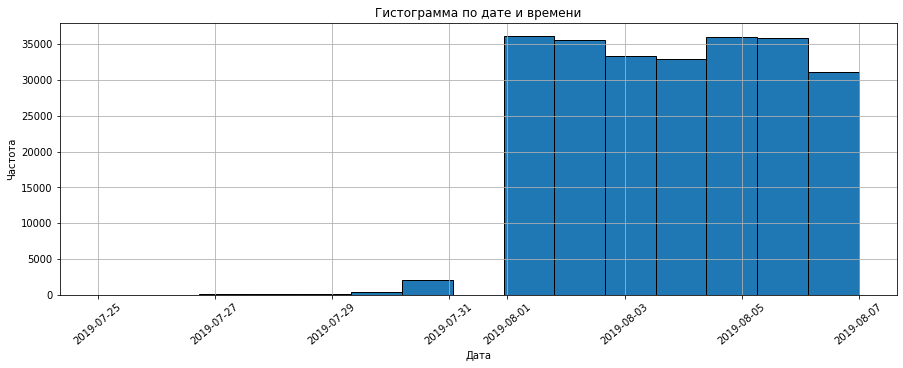

In [24]:
#гистограмма по дате и времени
plt.figure(figsize =(15, 5))
logs['date'].hist(bins=15, edgecolor='black')
plt.title('Гистограмма по дате и времени')
plt.xlabel('Значение')
plt.xticks(rotation=40)
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.show()

In [25]:
param = 'date'

In [26]:
df_agg = logs.groupby(param, as_index=False).agg({'event_timestamp': 'count'})

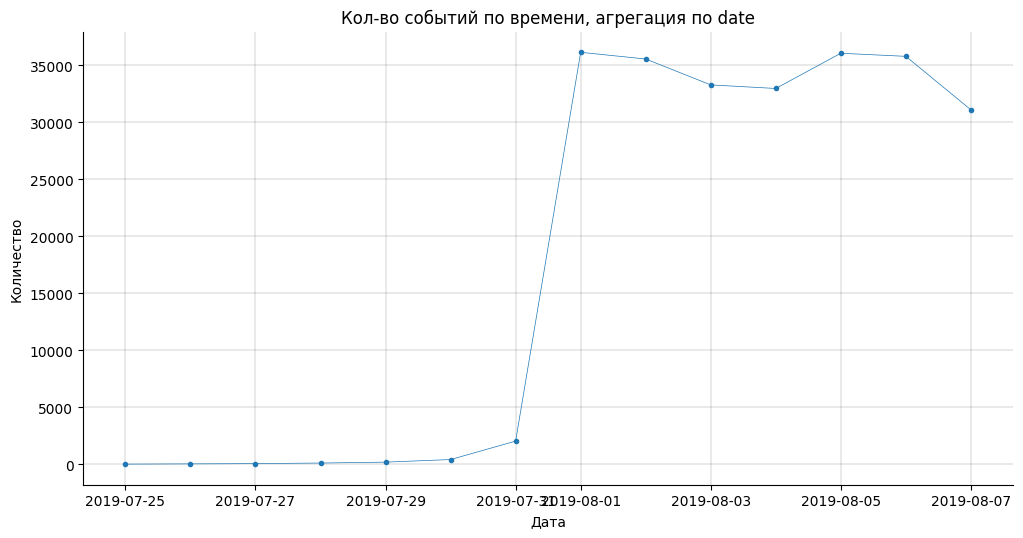

In [27]:
_, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.despine(ax=ax)
ax.plot(df_agg[param], df_agg['event_timestamp'], marker='o', ms=3, lw=0.5)
ax.grid(color='grey', lw=0.25)
ax.set_title(f"Кол-во событий по времени, агрегация по {param}")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество");

Мы располагаем данными за 2 недели, но, как видим на графике, не все данные полные и позволяют производить корректный анализ. От неполных необходимо избавиться.

In [28]:
#в новом датафрейме оставляем только полные данные
df = logs.loc[logs['date'] >= '2019-08-01']

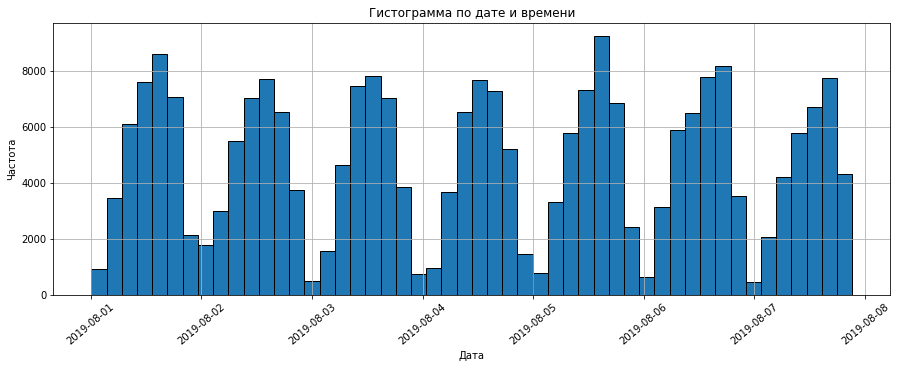

In [29]:
#гистограмма по дате и времени (2)
plt.figure(figsize =(15, 5))
ax = df['date_time'].hist(bins=50, edgecolor='black')
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(rotation=40)
plt.show()

In [30]:
print('Мы располагаем полными данными в период с', df['date_time'].min(), 'по', df['date_time'].max())

Мы располагаем полными данными в период с 2019-08-01 00:07:28 по 2019-08-07 21:15:17


In [31]:
print('Количество событий в логе до отчистки:', len(logs['event_name']))
print('Количество событий в логе после отчистки:', len(df['event_name']))
print(round(len(logs['event_name']) / len(df['event_name'])), '% пользователей утерян при отбросе данных')

Количество событий в логе до отчистки: 243713
Количество событий в логе после отчистки: 240887
1 % пользователей утерян при отбросе данных


In [32]:
print('Количество уникальных пользователей в логе до отчистки:', len(logs['user_id'].unique()))
print('Количество уникальных пользователей в логе после отчистки:', len(df['user_id'].unique()))
print(round(len(logs['user_id'].unique()) / len(df['user_id'].unique())), '% пользователей утерян при отбросе данных')

Количество уникальных пользователей в логе до отчистки: 7551
Количество уникальных пользователей в логе после отчистки: 7534
1 % пользователей утерян при отбросе данных


In [33]:
#проверяем, что есть пользователи из всех трёх экспериментальных групп
df.groupby('group').agg({'user_id': 'nunique'})

user_id
group         
A1        2484
A2        2513
B         2537

In [34]:
#проверим, есть ли значения, которые встречаются в А1 и А2
len(np.intersect1d(logs.query('exp_id == 246')['user_id'].unique(), logs.query('exp_id == "247"')['user_id'].unique()))

0

In [35]:
#проверим, есть ли значения, которые встречаются в А1 и в В
len(np.intersect1d(logs.query('exp_id == 246')['user_id'].unique(), logs.query('exp_id == "248"')['user_id'].unique()))

0

In [36]:
#проверим, есть ли значения, которые встречаются в А2 и в В
len(np.intersect1d(logs.query('exp_id == 247')['user_id'].unique(), logs.query('exp_id == "248"')['user_id'].unique()))


0

#### Вывод
Изучение и провека данных завершены. 

В логе: 5 уникальных событий, общее количество событий 243713;
7551 уникальный пользователь, на каждого из которых приходятся 32 события.

Получены данные за 13 дней, но не все они пригодны для анализа. Оставив только полные данные мы получили период с 2019-08-01 по 2019-08-07. 

В процессе очистки данных был утерян 1% уникальных пользователей и событий, что не критично.

Во всех эксперементальных группах есть пользователи, примерное число которых 2500.

### Изучение воронки событий

In [37]:
logs_events = df['event_name'].value_counts().reset_index()

In [38]:
#события в логах и их частота
logs_events

index  event_name
0         MainScreenAppear      117328
1       OffersScreenAppear       46333
2         CartScreenAppear       42303
3  PaymentScreenSuccessful       33918
4                 Tutorial        1005

In [39]:
logs_events_users = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index().rename(columns={'user_id': 'total_users'})

In [40]:
#количество пользователей, совершивших событие
logs_events_users

event_name  total_users
0         MainScreenAppear         7419
1       OffersScreenAppear         4593
2         CartScreenAppear         3734
3  PaymentScreenSuccessful         3539
4                 Tutorial          840

In [41]:
#% пользователей совершивших действие
logs_events_users['percent'] = round(logs_events_users['total_users'] / df['user_id'].nunique() * 100,2)
logs_events_users

event_name  total_users  percent
0         MainScreenAppear         7419    98.47
1       OffersScreenAppear         4593    60.96
2         CartScreenAppear         3734    49.56
3  PaymentScreenSuccessful         3539    46.97
4                 Tutorial          840    11.15

Событие Tutorial самое редковстречающееся. Предположение почему оно оказалось внизу воронки: пользователи проходят руководство в начале пользования ресурсом и, вероятно, это нужно далеко не всем. Это может говорить о том, что большинство пользователей считают, что приложением можно пользоваться интуитивно, интерфейс довольно понятный и удобный, что является плюсом. Если оставим Tutorial в воронке, это испортит данные. Поэтому было принято решение отбросить данное событие, чтобы не нарушать цепочку. 
Просмотр главного экрана расположился на верхней ступени воронки. 98,5% пользователей посещают его. Далее идут предложения, окно оплаты картой и окно с уведомлением о удачной оплате. В целом, воронка идет с логичным распределением конверсии.

In [42]:
#удаляем событие Tutorial
logs_events_users = logs_events_users[:4]

In [43]:
#создание столбца step_share с помощью shift
logs_events_users['step_share'] = round((logs_events_users['percent']/logs_events_users['percent'].shift(1, fill_value = 98.47))*100,2)

/tmp/ipykernel_79/2847306923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_events_users['step_share'] = round((logs_events_users['percent']/logs_events_users['percent'].shift(1, fill_value = 98.47))*100,2)


In [44]:
logs_events_users

event_name  total_users  percent  step_share
0         MainScreenAppear         7419    98.47      100.00
1       OffersScreenAppear         4593    60.96       61.91
2         CartScreenAppear         3734    49.56       81.30
3  PaymentScreenSuccessful         3539    46.97       94.77

На первом шаге теряются больше всего пользователей. 38,09% пользователей уходят от нас посмотрев на главный экран(MainScreenAppear) и даже без перехода к каталогу товаров(OffersScreenAppear). Это может говорить о том что интерфейс основной страницы неудобен или некорректно отображается на части устройств. Далее конверсия увеличивается от шага к шагу.

In [45]:
#считаем долю пользователей
share = round(logs_events_users['total_users'][3]/logs_events_users['total_users'][0] *100,2)

In [46]:
print('Доля пользователей доходящих от первого события до оплаты', share)

Доля пользователей доходящих от первого события до оплаты 47.7


#### Вывод


Были изучены события в логах: Tutorial, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, MainScreenAppear. 

Чаще всего встречается событие MainScreenAppear - появление главного экрана(7419). Меньше всего встречается событие Tutorial (840). Для успешного анализа воронки, событие Tutorial пришлось отбросить.

По данным из воронки мы получили такие данные:
61.9% переходят на шаг от MainScreenAppear до OffersScreenAppear
81.3% переходят на шаг от OffersScreenAppear до CartScreenAppear
94.7% переходят на шаг от CartScreenAppear до PaymentScreenSuccessful.

Меньше половины пользоваателей проходят от первого события до оплаты товара, а именно 47.7% пользователей.



### Изучение результатов эксперимента

In [47]:
df

event_name              user_id     event_timestamp  exp_id  \
2828              Tutorial  3737462046622621720 2019-08-01 00:07:28     246   
2829      MainScreenAppear  3737462046622621720 2019-08-01 00:08:00     246   
2830      MainScreenAppear  3737462046622621720 2019-08-01 00:08:55     246   
2831    OffersScreenAppear  3737462046622621720 2019-08-01 00:08:58     246   
2832      MainScreenAppear  1433840883824088890 2019-08-01 00:08:59     247   
...                    ...                  ...                 ...     ...   
244121    MainScreenAppear  4599628364049201812 2019-08-07 21:12:25     247   
244122    MainScreenAppear  5849806612437486590 2019-08-07 21:13:59     246   
244123    MainScreenAppear  5746969938801999050 2019-08-07 21:14:43     246   
244124    MainScreenAppear  5746969938801999050 2019-08-07 21:14:58     246   
244125  OffersScreenAppear  5746969938801999050 2019-08-07 21:15:17     246   

                 date_time       date group  
2828   2019-08-01 00:07:28 2019-08-01    A1  
2829   2019-08-01 00:08:00 2019-08-01    A1  
2830   2019-08-01 00:08:55 2019-08-01    A1  
2831   2019-08-01 00:08:58 2019-08-01    A1  
2832   2019-08-01 00:08:59 2019-08-01    A2  
...                    ...        ...   ...  
244121 2019-08-07 21:12:25 2019-08-07    A2  
244122 2019-08-07 21:13:59 2019-08-07    A1  
244123 2019-08-07 21:14:43 2019-08-07    A1  
244124 2019-08-07 21:14:58 2019-08-07    A1  
244125 2019-08-07 21:15:17 2019-08-07    A1  

[240887 rows x 7 columns]

In [48]:
#число уникальных пользователей в каждой группе
df.groupby('group')['user_id'].nunique() #вместо exp_id группируем по group, что соответствует A1, A2, B

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Мы получили удовлетворительное число пользоватей в каждой из групп для проведения тестирования.

In [49]:
logs_a1 = df.query('group == "A1"').groupby('group')['user_id'].nunique().reset_index()
logs_a2 = df.query('group == "A2"').groupby('group')['user_id'].nunique().reset_index()

In [50]:
#находим различие в группах
difference = 1 - logs_a1.iloc[0]['user_id'] / logs_a2.iloc[0]['user_id']
print('Число пользователей в группах А1 и А2 различается на {:.2%}'.format(difference))

Число пользователей в группах А1 и А2 различается на 1.15%


Различие не критично.

In [51]:
df.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values('A1',ascending=False)

group                      A1    A2     B
event_name                               
MainScreenAppear         2450  2476  2493
OffersScreenAppear       1542  1520  1531
CartScreenAppear         1266  1238  1230
PaymentScreenSuccessful  1200  1158  1181
Tutorial                  278   283   279

MainScreenAppear - наиболее популярное событие из лога.

####  А/А тест

С помощью функции будем выявлять статистическую значимость между группами.


Гипотезы:
Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы

Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы

Пороговое значение alpha примем за 5%.

In [52]:
def test(data, group_ids, alpha):
    #ищем уникальных пользователей в каждой группе
    users = [df.query('exp_id == @group_id')['user_id'].nunique() for group_id in group_ids]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in df.event_name.unique():
        events = [df.query('exp_id == %d and event_name == "%s"' % (group_id, event))['user_id'].nunique() for group_id in group_ids]
        # сравниваем кол-во уникальных пользователей на каждом шаге группы к кол-ву уникальных пользователей в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = st.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s' % (event))
            
        print(' ')

In [53]:
#результаты в группах A1 и A2 
test(df, [246, 247], 0.05)

Tutorial
0.11191626409017713 0.11261440509351373
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9863123993558777 0.9852765618782332
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6207729468599034 0.6048547552725826
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.5096618357487923 0.4926382809391166
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.4830917874396135 0.46080382013529647
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


Таким образом, мы получили результат, что все различия между событиями в группах А1 и А2 не являются статистически значимыми. Обе контрольные группы показали идентичные результаты. Можно приступать к А/B тестированию.

####  А/В тест

Теперь можем проводить А/В тест и проверить есть ли в группах статистически значимые различия.

In [54]:
#проводим тест А1 и В
test(df, [246, 248], 0.05)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.4830917874396135 0.46551044540796216
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


Различия между экспериментальными группами А1 и В статистически не значимы.

In [55]:
#проводим тест А2 и В
test(df, [247, 248], 0.05)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


Различия между экспериментальными группами А2 и В  тоже оказались статистически не значимы.

In [56]:
#соединим две группы в одну и оставим ее под номером 247
a12 = df.copy()
a12['exp_id'].replace({246: 247}, inplace=True)
a12['exp_id'].value_counts()

247    156324
248     84563
Name: exp_id, dtype: int64

In [57]:
#проводим тест соединенных групп А1+А2 и В
test(a12, [247, 248], 0.05)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


Снова получаем статистически не значимые события. Оснований чтобы считать доли разными нет.

Изменение шрифта никак не повлияло на пользователей.

При проверке мною был выбран уровень значимости alpha = 0.05, но нам известно, что при что при множественном тестировании вероятность ошибки первого рода, а именно ситуация, когда отвергнута верная нулевая гипотеза, возрастает.
Поэтому для того чтобы снизить вероятность ошибки, нужно применить метод Бонферрони. 

4 А/А-теста и 12 А/В-тестов.

0.05/16 = 0.003.

In [58]:
#тестирование групп с поправкой Бонферрони
test(df, [246, 248], 0.003)

Tutorial
0.11191626409017713 0.10997240835632636
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9863123993558777 0.9826566811194324
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.5096618357487923 0.48482459597950334
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.4830917874396135 0.46551044540796216
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


In [59]:
#тестирование групп с поправкой Бонферрони
test(df, [247, 248], 0.003)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


In [60]:
#тестирование групп с поправкой Бонферрони
test(a12, [247, 248], 0.003)

Tutorial
0.11261440509351373 0.10997240835632636
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу по событию Tutorial
 
MainScreenAppear
0.9852765618782332 0.9826566811194324
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear
 
OffersScreenAppear
0.6048547552725826 0.6034686637761135
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear
 
CartScreenAppear
0.4926382809391166 0.48482459597950334
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear
 
PaymentScreenSuccessful
0.46080382013529647 0.46551044540796216
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful
 


#### Вывод

Исходя из результатов данного эксперимента, мы можем сделать вывод, что на поведение пользователей изменение шрифта значимого эффекта не оказало. 


###  ВЫВОД

В ходе данной работы мы использовали данные с логами. Проведена предобработка данных. 

Анализируя гистиграмму, оставили только полные данные, благодаря которым совершили исследование. Полными данными мы располагали за период с 01.08.2019 по 08.08.2019. По окончанию обработки данных мы потеряли всего 1%, что не является критичным объемом. 

Изучая воронку мы выявили, что от главной страницы до оплаты доходят всего 47.7% пользователей. Это меньше половины и,на мой взгляд, нужно разрабатывать решение, чтобы увелисить конверсию. 

Группы для А/А/В-тестирования оказались равномерно сформированы. Было проведено 16 проверок статистических гипотез ни одна из которых не выявила значимой разницы. А это значит что замена шрифтов никак не повлияла на пользователей и выручка компании, в связи с этим событием, никак не изменилась.